# New Contributors Pull Requests

This is the reference implementation for [New Contributors Pull Requests](), a metric specified by the [Evolution Working group](https://github.com/chaoss/wg-evolution) of the [CHAOSS project](https://chaoss.community/). This implementation is specific to GitHub repositories.

Have a look at [README.md](../README.md) to find out how to run this notebook (and others in this directory) as well as
to get a better understanding of the purpose of the implementations.

The implementation is desvcribed in two parts (see below):

* Class for computing New Contributors Pull Requests
* An explanatory analysis of the class' functionality

Some more auxiliary information in this notebook:

* Examples of the use of the implementation
* Vizualizing the data extracted

As discussed in the [README.md](../README.md) file, the scripts required to analyze the data fetched by Perceval are
located in the `code_df` package. Due to python's import system, to import modules from a package which is not in the
current directory, we have to either add the package to `PYTHONPATH` or simply append a `../..` to `sys.path`, so that
`code_df` can be successfully imported.

In [5]:
from datetime import datetime
import matplotlib.pyplot as plt
%matplotlib inline

import sys

sys.path.append("../..")

from implementations.code_df.pullrequest_github import PullRequestGitHub
from implementations.code_df.utils import read_json_file

In [6]:
class NewContributorsPullRequestsGitHub(PullRequestGitHub):
    """
    Class for New Contributors Pull Requests in GitHub
    """

    def __init__(self, items, date_range=(None, None)):
        """
        Initializes self.df, the dataframe with one commit per row.

        :param items: A list of dictionaries.
            Each item is a Perceval dictionary, obtained from a JSON
            file or from Perceval directly.

        :param date_range: A tuple which represents the start and end date
            between which new contributors will be considered.
            Either, or both can be None. If, for example, since is None, that
            all unique contributors whose commit lies between the first pull request
            to the pull request which last falls inside the until range would be considered
            unique contributors.
        """
        super().__init__(items, date_range)

        self.df = self.df.loc[self.df.groupby('author')['created_date'].idxmin()]

        if self.since:
            self.df = self.df[self.df['created_date'] >= self.since]

        if self.until:
            self.df = self.df[self.df['created_date'] <= self.until]

    def compute(self):
        """
        Count the number of new contributors who has created an pull request
        between the two dates
        of date_range.

        :returns count_of_new_contributors: the number of new contributors who
            created a new pull request between the dates of date_range

            Since the dataframe self.df is modified in __init__ via groupby
            and idmin(), the number of unique entries in the dataframe gives us the number of the new contributors between the given dates.
        """
        return len(self.df.index)

    def _agg(self, df, period):
        """
        Perform an aggregation operation on a DataFrame or Series
        to count the number of new contributors in a period when
        compared to contributors before that period.

        This method uses the 'count' aggregation method.

        :param df: a pandas DataFrame on which the aggregation will be
            applied.

        :param period: A string which can be any one of the pandas time
            series rules:
            'W': week
            'M': month
            'D': day

        :returns df: The final aggregated DataFrame
        """
        return df.resample(period)['author'].agg(['count'])

    def _get_params(self):
        """
        Return paramters for creating a timeseries plot

        :returns: A dictionary with axes to plot, a title
            and if use_index should be true when creating
            the plot.
        """
        title = "Trends in the Number of New Contributors"
        x = None
        y = 'count'
        use_index = True
        return {'x': x, 'y': y, 'title': title, 'use_index': use_index}

    def __str__(self):
        return "New Contributors of Pull Requests"

## Performing the Analysis

Using the above class, we can perform several kinds of analysis on the JSON data file, fetched by Perceval.

At its most basic, the `NewContributorsPullRequestsGitHub` class can be used to get the number of contributors over the
entire interval for which commits are considered.

The `date_range` parameter talks about the period in which we will look for the new contributors.

### Counting the total number of contributors

We pass the data of the JSON file as a list to NewContributorsPullRequestsGitHub to start off.

In [7]:
items = read_json_file("../pull_requests.json")

Let's use the compute method to count the total number of valid commits made. First, we will do it without passing any
`since` and `until` dates. When no values are passed for `date_range`, every contributor to make a commit is a new
contributor and hence, we get the total number of unique contributors in the data considered.

In [8]:
new_contributors = NewContributorsPullRequestsGitHub(items)
print("New Contributors, total: {}".format(new_contributors.compute()))

New Contributors, total: 39


### Counting contributors in a specific range

Now, let's give the `date_range` tuple, which has `since` and `until` as its elements some values. Let's pass 2018-01-01
and 2018-07-01 for `date_range`. Thus, we will be looking for new contributors who made their first pull request between
2018-01-01 and 2018-07-01.

In [9]:
date_since = datetime.strptime("2018-01-01", "%Y-%m-%d")
date_until = datetime.strptime("2018-07-01", "%Y-%m-%d")
new_contributors_interval = NewContributorsPullRequestsGitHub(items, (date_since, date_until))
print("New Contributors, between 2018-01-01 and 2018-07-01: ", new_contributors_interval.compute())

New Contributors, between 2018-01-01 and 2018-07-01:  13


### Counting new contributors whose made first pull request over regular time intervals

Using the `time_series` method, it is possible to compute the number of new contributors for every month, or for every
week. This kind of analysis is useful in finding trends over time, as we will see in the cell below. Let's see the trend
in the number of new contributors who made first pull request between the same dates we used above, on a weekly basis:
2018-01-01 and 2018-07-01. We will use the same object we used when working with the dates above:
`new_contributors_interval`

In [10]:
weekly_df = new_contributors_interval.time_series(period='W')

Let's see what the dataframe returned by `time_series` looks like. As you will notice, the dataframe has rows
corresponding to the weeks between the dates passed. This was done by performing a simple resampling with the desired
time period.

In [11]:
weekly_df

,count
created_date,
2018-01-07,3
2018-01-14,1
2018-01-21,0
2018-01-28,2
2018-02-04,2
2018-02-11,0
2018-02-18,0
2018-02-25,0
2018-03-04,0


Let's plot the dataframe `weekly_df` using `matplotlib.pyplot`. We use the `seaborn` theme and plot a simple bar plot
--- `new_contributors` count vs time interval.

Text(0.5, 1.0, 'New Contributors')

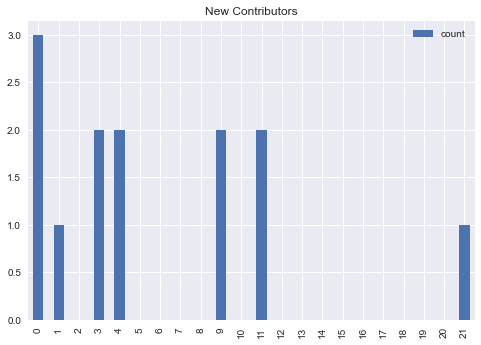

In [12]:
plt.style.use('seaborn')
weekly_df.plot(kind='bar', y='count', use_index=False)
plt.title("New Contributors")

The same thing can be done for months, instead of weeks. By passing `month` in place of week, we get a similar dataframe
but with only a few rows, due to the larger timescale of each period.

In [13]:
monthly_df = new_contributors_interval.time_series(period='M')

In [14]:
monthly_df

,count
created_date,
2018-01-31,7
2018-02-28,1
2018-03-31,4
2018-04-30,0
2018-05-31,1


Text(0.5, 1.0, 'New Contributors')

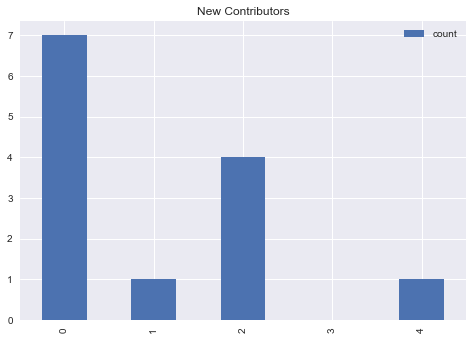

In [15]:
plt.style.use('seaborn')
monthly_df.plot(kind="bar", y='count', use_index=False)
plt.title("New Contributors")